In [19]:
import harp
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import cv2
import numpy as np
import utils
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers

harp_reader = harp.create_reader('device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData()
rules_reader = utils.SessionData()
video_reader = utils.Video()

harp_datafolder = r'../temp_data/2024-03-06T18-02-52/Expander/'
settings_datafolder = r'../temp_data/2024-03-06T18-02-52/SessionSettings/'
rules_datafolder = r'../temp_data/2024-03-06T18-02-52/RuleSettings/'
video_datafolder = r'../temp_data/2024-03-06T18-02-52/VideoData/'
output_event_folder = r'../temp_data/2024-03-06T18-02-52/EventResults/'

In [3]:
# read experiment metadata
session_settings = utils.load_json(session_data_reader, settings_datafolder)

rule_settings = utils.load_json(rules_reader, rules_datafolder)

print(session_settings)
print(rule_settings)

                                                                     metadata
2024-03-06 18:02:52.827487  {'lineMappings': {'odorMap': [DotMap(name='Odo...
                                                                     metadata
2024-03-06 18:02:52.827487  {'ruleAlias': 'Rule1', 'stateDefinitions': [{'...


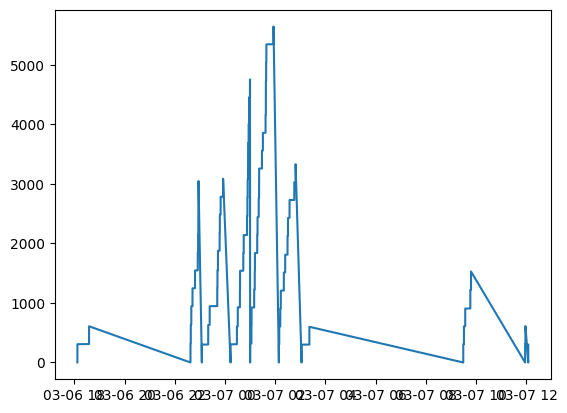

In [4]:
# read experiment video
video_data = utils.load_video(video_reader, video_datafolder)

plt.plot(video_data.index, video_data["_frame"])

In [5]:
# Read HARP device streams, conditioned on mappings found in the session metadata
metadata = session_settings.iloc[0]['metadata']
print(metadata)

# Extract line mappings from metadata
aux_line = f'Aux{metadata.lineMappings.auxLine}'
port_line = f'Out{metadata.lineMappings.portLine}'
vacuum_line = f'Out{metadata.lineMappings.vacuumLine}'
odorA = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorA'), None)}"
odorB = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorB'), None)}"
odorC = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorC'), None)}"
odorD = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorD'), None)}"

# Aux line containing poke events
poke_events = utils.load(harp_reader.AuxInState, harp_datafolder)[aux_line]

# times when outputs were set to HIGH (e.g. port valve opening, manifold valve opening)
outputs_HIGH = utils.load(harp_reader.OutputSet, harp_datafolder)
# times when outputs were set to LOW (e.g. port valve closing, manifold closing)
outputs_LOW = utils.load(harp_reader.OutputClear, harp_datafolder)

# convert LOW and HIGH events to port state dataframes
line_states = {
    "poke_events": poke_events,
    "port_line_state": utils.concat_digi_events(outputs_LOW[port_line], outputs_HIGH[port_line]),
    "vacuum_line_state": utils.concat_digi_events(outputs_LOW[vacuum_line], outputs_HIGH[vacuum_line]),
    "odorA_state": utils.concat_digi_events(outputs_LOW[odorA], outputs_HIGH[odorA]),
    "odorB_state": utils.concat_digi_events(outputs_LOW[odorB], outputs_HIGH[odorB]),
    "odorC_state": utils.concat_digi_events(outputs_LOW[odorC], outputs_HIGH[odorC]),
    "odorD_state": utils.concat_digi_events(outputs_LOW[odorD], outputs_HIGH[odorD])
}

# consolidate digital lines into as single DataFrame
merged = pd.merge(line_states["poke_events"], line_states["port_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["vacuum_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorA_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorB_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorC_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorD_state"], left_on="Time", right_on="Time", how="outer")

# rename columns according to metadata line mapping
merged.columns = line_states.keys()

# add additional meta information
merged['poke_count'] = (merged['poke_events'] * 1).cumsum(skipna=True).ffill()
merged['odor_count'] = (merged['odorA_state'] * 1).cumsum(skipna=True).ffill() + (merged['odorB_state'] * 1).cumsum(skipna=True).ffill() + \
                       (merged['odorC_state'] * 1).cumsum(skipna=True).ffill() + (merged['odorD_state'] * 1).cumsum(skipna=True).ffill()

print(merged)


DotMap(lineMappings=DotMap(odorMap=[DotMap(name='OdorA', line=6), DotMap(name='OdorB', line=7), DotMap(name='OdorC', line=8), DotMap(name='OdorD', line=9)], auxLine=0, portLine=0, vacuumLine=2), metadata=DotMap(switchTime1=0.01, switchTime2=0.02, useVacuum=False, vacuumDelay=0.005, vacuumDuration=0.05, chargeTime=0.2, minimumPokeTime=0.01, minOdorDelivery=0.1, maxOdorDelivery=8.0, loggingRootPath='C:\\Users\\court\\temp_data', animalId='plimbo', remoteTransferRootPath='', maximumPokeTime=10.0, robocopyTimeInterval=3600.0, showHarpLeds=True, maxVideoLength=20.0), cameraProperties=DotMap(imagingRate=60.0, exposureTime=10000, postEventTime=2.5, preEventTime=2.5))
                              poke_events port_line_state vacuum_line_state  \
Time                                                                          
2024-03-06 18:02:54.968480110         NaN           False               NaN   
2024-03-06 18:02:55.009503841         NaN             NaN               NaN   
2024-03-06 18:0

C:\Users\erski\AppData\Local\Temp\ipykernel_12812\1209327517.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['poke_count'] = (merged['poke_events'] * 1).cumsum(skipna=True).ffill()
C:\Users\erski\AppData\Local\Temp\ipykernel_12812\1209327517.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['odor_count'] = (merged['odorA_state'] * 1).cumsum(skipna=True).ffill() + (merged['odorB_state'] * 1).cumsum(skipna=True).ffill() + \
C:\Users\erski\AppData\Local\Temp\ipykernel_12812\1209327517.py:47: FutureWarning: Downcasting object dtype arra

C:\Users\erski\AppData\Local\Temp\ipykernel_12812\1360420589.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cur_state = experiment_state.ffill().loc[experiment_state.index <= event_time].iloc[[-1]]
C:\Users\erski\AppData\Local\Temp\ipykernel_12812\1360420589.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cur_odor = [state for state in ['odorA_state', 'odorB_state', 'odorC_state', 'odorD_state'] if cur_state[state][0]]
C:\Users\erski\AppData\Local\Temp\ipykernel_12812\1360420589.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated an

[Text(0, -0.25, 'event'),
 Text(0, 0.55, 'poke'),
 Text(0, 1.65, 'port_line'),
 Text(0, 2.75, 'odorA'),
 Text(0, 3.85, 'odorB'),
 Text(0, 4.95, 'odorC'),
 Text(0, 6.05, 'video_frames')]

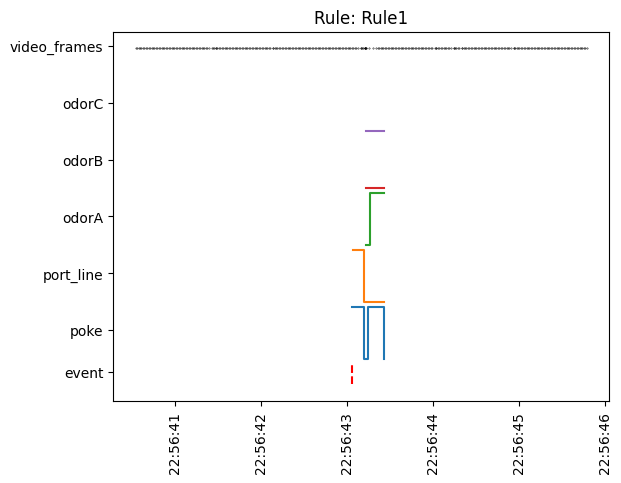

In [20]:
# Using the consolidated data sets, do an example plot centered around a poke event

def extract_event_info(experiment_state: pd.DataFrame, rule_state: pd.DataFrame, event_time: pd.Timestamp, time_offset: float):
    # get time window around event
    start_time = event_time - pd.Timedelta(seconds=time_offset)
    end_time = event_time + pd.Timedelta(seconds=time_offset)

    # slice data in this time window
    event_data = experiment_state[start_time : end_time]
    event_vid = video_data[start_time : end_time]

    # additional meta information
    cur_state = experiment_state.ffill().loc[experiment_state.index <= event_time].iloc[[-1]]
    cur_odor = [state for state in ['odorA_state', 'odorB_state', 'odorC_state', 'odorD_state'] if cur_state[state][0]]
    cur_odor = cur_odor[0] if len(cur_odor)>0 else None
    current_rule = rule_state[rule_state.index <= event_time]["metadata"].iloc[-1]

    time_beam_break_on = event_time
    time_beam_break_off = experiment_state.loc[(experiment_state['poke_events'] == False) & (experiment_state.index > event_time)].index[0]

    time_port_open = experiment_state.loc[(experiment_state['port_line_state'] == True) & (experiment_state.index > event_time)].index[0]
    time_port_close = experiment_state.loc[(experiment_state['port_line_state'] == False) & (experiment_state.index > event_time)].index[0]

    time_odor_open = experiment_state.loc[(experiment_state[cur_odor] == True) & (experiment_state.index <= event_time)].index[0] if cur_odor else None
    time_odor_close = experiment_state.loc[(experiment_state[cur_odor] == False) & (experiment_state.index > event_time)].index[0] if cur_odor else None

    next_poke_valves = (experiment_state[experiment_state.index > time_port_close])[['odorA_state', 'odorB_state', 'odorC_state', 'odorD_state']].sum(axis=1)
    next_odor_time = next_poke_valves[next_poke_valves == 1].index[0]
    next_poke_time = experiment_state.loc[(experiment_state.index > time_port_close) & (experiment_state['poke_events'] == True)]['poke_events'].index[0]

    # summarise in data frame
    event_df = pd.DataFrame({
        'current_rule': current_rule.ruleAlias,
        'poke_state': cur_state['poke_events'],
        'port_line_state': cur_state['port_line_state'],
        'vacuum_line_state': cur_state['vacuum_line_state'],
        'odorA_state': cur_state['odorA_state'],
        'odorB_state': cur_state['odorB_state'],
        'odorC_state': cur_state['odorC_state'],
        'odorD_state': cur_state['odorD_state'],
        'poke_count': cur_state['poke_count'],
        'odor_count': cur_state['odor_count'],
        'beam_break_on': time_beam_break_on,
        'beam_break_off': time_beam_break_off,
        'port_open': time_port_open,
        'port_close': time_port_close,
        'odor_open': time_odor_open,
        'odor_close': time_odor_close,
        'next_odor': next_odor_time,
        'next_poke': next_poke_time
    }).reset_index()

    return event_data, event_vid, event_df

# Get all the poke onset events, then extract the event times
poke_events = merged["poke_events"][merged["poke_events"]==True] # as an example we here pick the time 3rd poke event time
poke_event_times = [poke_events.iloc[[t]].index[0] for t in range(len(poke_events)-1)]
    
results = [extract_event_info(merged, rule_settings, t, 10.0) for t in poke_event_times]
summary = pd.concat([r[2] for r in results]).reset_index()
summary.to_csv(f'{output_event_folder}summary.csv')

# Construct a plot of one of these results
event_idx = 16
event_data = results[event_idx][0]
event_vid = results[event_idx][1]
event_df = results[event_idx][2]
fig = plt.figure()

plt.plot([event_df["Time"], event_df["Time"]], [-0.5, -0.1], c='r', linestyle='dashed')
plt.plot(event_data["poke_events"].ffill(), drawstyle = 'steps-post')
plt.plot(event_data["port_line_state"].ffill() + 1.1, drawstyle = 'steps-post')
plt.plot(event_data["odorA_state"].ffill() + 2.2, drawstyle = 'steps-post')
plt.plot(event_data["odorB_state"].ffill() + 3.3, drawstyle = 'steps-post')
plt.plot(event_data["odorC_state"].ffill() + 4.4, drawstyle = 'steps-post')
plt.scatter(event_vid.index, np.ones((1, len(event_vid.index))) * 6, c='k', s=0.1)
plt.xticks(rotation=90)
plt.title(f"Rule: {event_df['current_rule'][0]}")

ax = fig.axes[0]
ax.set_yticks([-0.25, 0.55, 1.65, 2.75, 3.85, 4.95, 6.05])
ax.set_yticklabels(['event', 'poke', 'port_line', 'odorA', 'odorB', 'odorC', 'video_frames'])

In [42]:
def create_event_video(experiment_state: pd.DataFrame, event_frame_data: pd.DataFrame, event_df: pd.DataFrame):
    # get all frames
    frames = [f for f in video.frames(event_frame_data)]

    # create annotated video
    annotated_frames = []
    event_time = event_df["Time"]
    for i, f in enumerate(frames):
        cur_t = event_frame_data.index[i]
        relative_t = (cur_t - event_time)[0].total_seconds()
        cur_state = experiment_state.ffill().loc[experiment_state.index <= cur_t].iloc[-1]
        current_rule = event_df["current_rule"][0]

        cv2.putText(f, f'Rule : {current_rule}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
        cv2.putText(f, f'HARP Time : {cur_t}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
        cv2.putText(f, f'Time to event (s) : {relative_t}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)

        cv2.putText(f, f"Aux state : {cur_state.fillna(False)['poke_events']}", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state.fillna(False)['poke_events'] else (0, 0, 255), 2, 1)
        cv2.putText(f, f"Port state : {cur_state['port_line_state']}", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['port_line_state'] else (0, 0, 255), 2, 1)
        cv2.putText(f, f"OdorA state : {cur_state['odorA_state']}", (10, 180), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorA_state'] else (0, 0, 255), 2, 1)
        cv2.putText(f, f"OdorB state : {cur_state['odorB_state']}", (10, 210), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorB_state'] else (0, 0, 255), 2, 1)
        cv2.putText(f, f"OdorC state : {cur_state['odorC_state']}", (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorC_state'] else (0, 0, 255), 2, 1)

        cv2.putText(f, f"Poke count : {cur_state['poke_count']}", (10, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
        annotated_frames.append(f)

    return annotated_frames
        
for i, r in enumerate(results):
    annotated = create_event_video(merged, r[1], r[2])
    print(f'{output_event_folder}Event-{i}-{str(r[2]["Time"][0]).replace(" ", "").replace(":", "T")}.mp4')
    video.export(annotated, f'{output_event_folder}Event-{i}-{str(r[2]["Time"][0]).replace(" ", "").replace(":", "T")}.mp4', 50)

C:\Users\erski\AppData\Local\Temp\ipykernel_12812\44567811.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cur_state = experiment_state.ffill().loc[experiment_state.index <= cur_t].iloc[-1]


../temp_data/2024-03-06T18-02-52/EventResults/Event-0-2024-03-0618T07T30.274367809.mp4
../temp_data/2024-03-06T18-02-52/EventResults/Event-1-2024-03-0618T07T30.396831989.mp4
../temp_data/2024-03-06T18-02-52/EventResults/Event-2-2024-03-0618T35T19.387104034.mp4
../temp_data/2024-03-06T18-02-52/EventResults/Event-3-2024-03-0622T37T34.364960194.mp4
../temp_data/2024-03-06T18-02-52/EventResults/Event-4-2024-03-0622T37T34.487679958.mp4
../temp_data/2024-03-06T18-02-52/EventResults/Event-5-2024-03-0622T37T34.694943905.mp4
../temp_data/2024-03-06T18-02-52/EventResults/Event-6-2024-03-0622T38T19.715616226.mp4
../temp_data/2024-03-06T18-02-52/EventResults/Event-7-2024-03-0622T38T19.952511787.mp4
../temp_data/2024-03-06T18-02-52/EventResults/Event-8-2024-03-0622T39T31.451424122.mp4


KeyboardInterrupt: 